In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
transform = transforms.Compose(
    [transforms.Resize(32),  # Resizing to 32x32
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def position_embedding_layer(num_patches, embedding_dimension, batch_size):
    result = torch.ones(num_patches + 1, embedding_dimension)  # Add 1 for the class token
    for i in range(num_patches + 1):  # Add 1 for the class token
        for j in range(embedding_dimension):
            if j % 2 == 0:
                result[i][j] = (np.sin(i / (10000 ** (j / embedding_dimension))))
            else:
                result[i][j] = np.cos(i / (10000 ** ((j - 1) / embedding_dimension)))
    result = result.unsqueeze(0).repeat(batch_size, 1, 1)
    return result

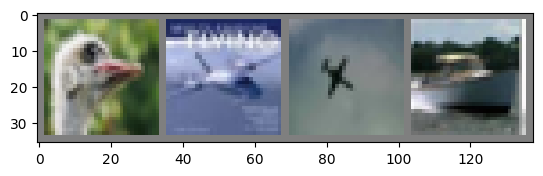

bird  plane plane ship 


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class ConditionalPositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_size, num_features):
        super(ConditionalPositionalEncoding, self).__init__()
        self.num_patches = num_patches
        self.embed_size = embed_size
        self.num_features = num_features
        self.fc = nn.Linear(num_features, embed_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_size))

    def forward(self, features):
        cond_embedding = self.fc(features)
        pos_embedding = self.pos_embedding.expand(features.size(0), -1, -1)
        combined_embedding = torch.cat([pos_embedding, cond_embedding.unsqueeze(1)], dim=1)
        return combined_embedding

def patchify(images, num_of_patches):
    batch_size, channels, height, width = images.shape

    assert height == width, "Patchify method is implemented for square images only"

    height_per_patch = height // num_of_patches
    width_per_patch = width // num_of_patches

    patches = torch.zeros(batch_size, num_of_patches ** 2, channels, height_per_patch, width_per_patch)

    for idx, image in enumerate(images):
        for i in range(num_of_patches):
            for j in range(num_of_patches):
                patch = image[
                    :,
                    i * height_per_patch: (i + 1) * height_per_patch,
                    j * width_per_patch: (j + 1) * width_per_patch,
                ]
                patches[idx, i * num_of_patches + j] = patch

    return patches


class Projection_Layer(nn.Module):
    def __init__(self, num_patches, patch_size, in_channels, embed_size):
        super(Projection_Layer, self).__init__()
        self.num_patches = num_patches
        self.layer_norm_1 = nn.LayerNorm(patch_size * patch_size * in_channels)
        self.embed_layer = nn.Linear(patch_size * patch_size * in_channels, embed_size)
        self.layer_norm_2 = nn.LayerNorm(embed_size)

    def forward(self, x):
        b, _, c, _, _ = x.shape
        x = x.permute(0, 1, 3, 4, 2)
        x = x.contiguous()
        x = x.view(b, self.num_patches, -1)
        x = self.layer_norm_1(x)
        x = self.embed_layer(x)
        x = self.layer_norm_2(x)

        return x


class Attention(nn.Module):
    def __init__(self, num_heads, embed_size):
        super(Attention, self).__init__()

        eff_embed_size = embed_size // num_heads
        self.num_heads = num_heads
        self.Q_matrix = nn.Linear(eff_embed_size, eff_embed_size)
        self.K_matrix = nn.Linear(eff_embed_size, eff_embed_size)
        self.V_matrix = nn.Linear(eff_embed_size, eff_embed_size)
        self.temperature = eff_embed_size ** 0.5

    def forward(self, x):
        bs, n_1, embed_dim = x.shape
        x = x.view(bs, self.num_heads, n_1, embed_dim // self.num_heads)
        q = self.Q_matrix(x)
        k = self.K_matrix(x)
        v = self.V_matrix(x)

        attention = nn.Softmax(dim=-1)(torch.matmul(q, k.transpose(-1, -2))) / self.temperature
        x = torch.matmul(attention, v)
        x = x.view(bs, n_1, embed_dim)
        return x


class Vision_Transformer(nn.Module):
    def __init__(self, image_size=32, in_channels=3, patch_size=8, embed_size=192, hidden_dim=512, num_heads=8,
                 num_layers=4, dropout=0.01, num_of_patches=4):
        super(Vision_Transformer, self).__init__()

        self.num_patches = (image_size // patch_size) ** 2
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.patch_size = patch_size
        self.in_channels = in_channels

        self.projection_layer = Projection_Layer(self.num_patches, patch_size, in_channels, embed_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))
        self.pos_emb = position_embedding_layer(self.num_patches, embed_size, 1)

        self.layers = nn.Sequential(*[Transformer_Block(num_heads, embed_size, hidden_dim, dropout)
                                      for _ in range(num_layers)])

        self.clf_head = nn.Linear(embed_size, 10)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = patchify(x, int(self.num_patches ** 0.5))
        x = self.projection_layer(x)

        cls_token = self.cls_token.expand(bs, -1, -1)
        x = torch.cat([cls_token, x], dim=1)

        x = x + self.pos_emb

        for layer in self.layers:
            x = layer(x)

        x = self.clf_head(x[:, 0, :])
        return x



In [ ]:
net = Vision_Transformer()


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

2013it [00:34, 69.99it/s]

[1,  2000] loss: 2.152


4012it [01:04, 61.88it/s]

[1,  4000] loss: 2.078


6012it [01:36, 67.81it/s]

[1,  6000] loss: 2.065


8011it [02:06, 59.26it/s]

[1,  8000] loss: 2.056


10008it [02:37, 45.24it/s]

[1, 10000] loss: 2.044


12010it [03:08, 67.79it/s]

[1, 12000] loss: 2.047


12500it [03:16, 63.72it/s]
2009it [00:30, 69.84it/s]

[2,  2000] loss: 2.024


4005it [01:01, 47.66it/s]

[2,  4000] loss: 2.022


6011it [01:32, 72.19it/s]

[2,  6000] loss: 2.014


8004it [02:03, 51.52it/s]

[2,  8000] loss: 2.008


10010it [02:34, 70.64it/s]

[2, 10000] loss: 2.016


12013it [03:05, 72.80it/s]

[2, 12000] loss: 2.007


12500it [03:13, 64.67it/s]
2010it [00:30, 51.99it/s]

[3,  2000] loss: 1.986


4013it [01:02, 70.96it/s]

[3,  4000] loss: 2.001


6006it [01:32, 57.05it/s]

[3,  6000] loss: 1.983


8009it [02:04, 72.72it/s]

[3,  8000] loss: 1.990


10006it [02:34, 56.13it/s]

[3, 10000] loss: 1.986


12013it [03:06, 71.51it/s]

[3, 12000] loss: 1.989


12500it [03:13, 64.61it/s]
2007it [00:31, 69.37it/s]

[4,  2000] loss: 1.956


4009it [01:01, 70.24it/s]

[4,  4000] loss: 1.974


6008it [01:33, 71.21it/s]

[4,  6000] loss: 1.972


8012it [02:03, 70.38it/s]

[4,  8000] loss: 1.968


10013it [02:35, 70.45it/s]

[4, 10000] loss: 1.970


12011it [03:05, 73.10it/s]

[4, 12000] loss: 1.972


12500it [03:13, 64.69it/s]
2012it [00:30, 64.81it/s]

[5,  2000] loss: 1.959


4009it [01:01, 70.51it/s]

[5,  4000] loss: 1.948


6014it [01:32, 70.18it/s]

[5,  6000] loss: 1.948


8006it [02:02, 43.78it/s]

[5,  8000] loss: 1.950


10007it [02:33, 72.45it/s]

[5, 10000] loss: 1.945


12010it [03:03, 64.62it/s]

[5, 12000] loss: 1.951


12500it [03:12, 64.89it/s]
2012it [00:31, 56.40it/s]

[6,  2000] loss: 1.916


4009it [01:01, 71.26it/s]

[6,  4000] loss: 1.941


6006it [01:31, 62.50it/s]

[6,  6000] loss: 1.934


8010it [02:03, 69.01it/s]

[6,  8000] loss: 1.937


10010it [02:33, 69.83it/s]

[6, 10000] loss: 1.939


12009it [03:04, 72.03it/s]

[6, 12000] loss: 1.940


12500it [03:11, 65.26it/s]
2011it [00:31, 69.79it/s]

[7,  2000] loss: 1.921


4007it [01:03, 54.82it/s]

[7,  4000] loss: 1.922


6009it [01:34, 71.31it/s]

[7,  6000] loss: 1.909


8007it [02:04, 72.76it/s]

[7,  8000] loss: 1.914


10009it [02:34, 70.58it/s]

[7, 10000] loss: 1.922


12009it [03:06, 68.97it/s]

[7, 12000] loss: 1.924


12500it [03:14, 64.24it/s]
2012it [00:31, 66.98it/s]

[8,  2000] loss: 1.908


4007it [01:02, 68.12it/s]

[8,  4000] loss: 1.904


6013it [01:34, 67.21it/s]

[8,  6000] loss: 1.910


8006it [02:05, 72.91it/s]

[8,  8000] loss: 1.899


10007it [02:36, 62.77it/s]

[8, 10000] loss: 1.900


12013it [03:08, 67.46it/s]

[8, 12000] loss: 1.912


12500it [03:15, 64.07it/s]
2011it [00:31, 73.80it/s]

[9,  2000] loss: 1.887


4011it [01:02, 71.34it/s]

[9,  4000] loss: 1.880


6014it [01:34, 70.55it/s]

[9,  6000] loss: 1.885


8011it [02:04, 70.92it/s]

[9,  8000] loss: 1.886


10009it [02:36, 69.32it/s]

[9, 10000] loss: 1.904


12012it [03:06, 67.46it/s]

[9, 12000] loss: 1.903


12500it [03:14, 64.18it/s]
2012it [00:30, 70.29it/s]

[10,  2000] loss: 1.869


4006it [01:02, 54.37it/s]

[10,  4000] loss: 1.859


6008it [01:33, 70.16it/s]

[10,  6000] loss: 1.877


8006it [02:06, 60.74it/s]

[10,  8000] loss: 1.886


10013it [02:37, 71.55it/s]

[10, 10000] loss: 1.871


12012it [03:10, 65.04it/s]

[10, 12000] loss: 1.877


12500it [03:18, 62.94it/s]
2013it [00:30, 71.41it/s]

[11,  2000] loss: 1.847


4006it [01:03, 61.51it/s]

[11,  4000] loss: 1.854


6009it [01:33, 68.54it/s]

[11,  6000] loss: 1.843


8011it [02:06, 70.50it/s]

[11,  8000] loss: 1.849


10012it [02:36, 71.40it/s]

[11, 10000] loss: 1.856


12012it [03:08, 60.33it/s]

[11, 12000] loss: 1.847


12500it [03:15, 63.95it/s]
2008it [00:33, 65.27it/s]

[12,  2000] loss: 1.822


4012it [01:03, 69.51it/s]

[12,  4000] loss: 1.832


6008it [01:35, 72.06it/s]

[12,  6000] loss: 1.831


8013it [02:05, 66.57it/s]

[12,  8000] loss: 1.816


10009it [02:38, 70.45it/s]

[12, 10000] loss: 1.840


12008it [03:08, 71.01it/s]

[12, 12000] loss: 1.816


12500it [03:16, 63.74it/s]
2011it [00:32, 69.83it/s]

[13,  2000] loss: 1.788


4010it [01:02, 71.76it/s]

[13,  4000] loss: 1.797


6012it [01:34, 72.62it/s]

[13,  6000] loss: 1.806


8008it [02:05, 70.25it/s]

[13,  8000] loss: 1.813


10014it [02:35, 70.23it/s]

[13, 10000] loss: 1.802


12005it [03:06, 45.09it/s]

[13, 12000] loss: 1.810


12500it [03:14, 64.38it/s]
2008it [00:31, 69.14it/s]

[14,  2000] loss: 1.801


4013it [01:02, 69.18it/s]

[14,  4000] loss: 1.770


6007it [01:33, 58.97it/s]

[14,  6000] loss: 1.787


8008it [02:04, 71.25it/s]

[14,  8000] loss: 1.781


10007it [02:35, 47.20it/s]

[14, 10000] loss: 1.788


12014it [03:07, 71.67it/s]

[14, 12000] loss: 1.786


12500it [03:14, 64.17it/s]
2013it [00:30, 73.58it/s]

[15,  2000] loss: 1.768


4005it [01:01, 46.41it/s]

[15,  4000] loss: 1.761


6010it [01:31, 70.09it/s]

[15,  6000] loss: 1.771


8007it [02:01, 66.53it/s]

[15,  8000] loss: 1.763


10007it [02:33, 69.90it/s]

[15, 10000] loss: 1.781


12007it [03:04, 71.49it/s]

[15, 12000] loss: 1.767


12500it [03:12, 64.99it/s]
2008it [00:31, 48.98it/s]

[16,  2000] loss: 1.743


4008it [01:02, 70.04it/s]

[16,  4000] loss: 1.739


6007it [01:34, 50.48it/s]

[16,  6000] loss: 1.754


8013it [02:05, 69.07it/s]

[16,  8000] loss: 1.770


10007it [02:37, 53.51it/s]

[16, 10000] loss: 1.756


12010it [03:08, 67.85it/s]

[16, 12000] loss: 1.769


12500it [03:16, 63.61it/s]
2008it [00:31, 66.96it/s]

[17,  2000] loss: 1.728


4004it [01:02, 44.12it/s]

[17,  4000] loss: 1.724


6009it [01:34, 67.32it/s]

[17,  6000] loss: 1.741


8008it [02:05, 47.23it/s]

[17,  8000] loss: 1.747


10011it [02:35, 67.31it/s]

[17, 10000] loss: 1.740


12010it [03:06, 71.39it/s]

[17, 12000] loss: 1.751


12500it [03:15, 64.01it/s]
2005it [00:31, 43.88it/s]

[18,  2000] loss: 1.713


4007it [01:02, 68.93it/s]

[18,  4000] loss: 1.732


6009it [01:33, 49.40it/s]

[18,  6000] loss: 1.715


8009it [02:04, 69.18it/s]

[18,  8000] loss: 1.739


10014it [02:34, 70.53it/s]

[18, 10000] loss: 1.721


12013it [03:07, 71.34it/s]

[18, 12000] loss: 1.727


12500it [03:14, 64.14it/s]
2013it [00:31, 68.04it/s]

[19,  2000] loss: 1.707


4012it [01:03, 51.10it/s]

[19,  4000] loss: 1.696


6013it [01:33, 67.63it/s]

[19,  6000] loss: 1.700


8005it [02:05, 46.95it/s]

[19,  8000] loss: 1.727


10013it [02:36, 71.40it/s]

[19, 10000] loss: 1.732


12006it [03:06, 70.13it/s]

[19, 12000] loss: 1.721


12500it [03:14, 64.24it/s]
2007it [00:32, 50.96it/s]

[20,  2000] loss: 1.692


4012it [01:03, 70.94it/s]

[20,  4000] loss: 1.683


6012it [01:35, 58.00it/s]

[20,  6000] loss: 1.699


8010it [02:05, 70.13it/s]

[20,  8000] loss: 1.713


10009it [02:36, 48.08it/s]

[20, 10000] loss: 1.715


12011it [03:07, 69.55it/s]

[20, 12000] loss: 1.720


12500it [03:15, 63.92it/s]
2009it [00:32, 65.59it/s]

[21,  2000] loss: 1.669


4013it [01:04, 65.56it/s]

[21,  4000] loss: 1.691


6013it [01:35, 71.01it/s]

[21,  6000] loss: 1.713


8007it [02:06, 56.05it/s]

[21,  8000] loss: 1.679


10009it [02:38, 70.78it/s]

[21, 10000] loss: 1.714


12013it [03:11, 66.16it/s]

[21, 12000] loss: 1.698


12500it [03:19, 62.80it/s]
2009it [00:33, 72.10it/s]

[22,  2000] loss: 1.686


4008it [01:06, 46.45it/s]

[22,  4000] loss: 1.689


6010it [01:36, 68.83it/s]

[22,  6000] loss: 1.686


8007it [02:10, 62.36it/s]

[22,  8000] loss: 1.693


10006it [02:40, 71.15it/s]

[22, 10000] loss: 1.662


12011it [03:13, 64.05it/s]

[22, 12000] loss: 1.683


12500it [03:20, 62.31it/s]
2012it [00:32, 62.61it/s]

[23,  2000] loss: 1.677


4012it [01:04, 70.26it/s]

[23,  4000] loss: 1.666


6007it [01:36, 70.98it/s]

[23,  6000] loss: 1.678


8008it [02:07, 69.98it/s]

[23,  8000] loss: 1.674


10011it [02:39, 70.51it/s]

[23, 10000] loss: 1.682


12007it [03:09, 71.33it/s]

[23, 12000] loss: 1.678


12500it [03:17, 63.28it/s]
2005it [00:31, 57.94it/s]

[24,  2000] loss: 1.639


4009it [01:03, 67.85it/s]

[24,  4000] loss: 1.671


6009it [01:34, 60.09it/s]

[24,  6000] loss: 1.678


8010it [02:06, 67.58it/s]

[24,  8000] loss: 1.664


10008it [02:37, 68.31it/s]

[24, 10000] loss: 1.674


12013it [03:08, 67.15it/s]

[24, 12000] loss: 1.676


12500it [03:17, 63.30it/s]
2007it [00:30, 69.85it/s]

[25,  2000] loss: 1.628


4005it [01:02, 44.98it/s]

[25,  4000] loss: 1.648


6012it [01:32, 68.99it/s]

[25,  6000] loss: 1.653


8013it [02:05, 61.28it/s]

[25,  8000] loss: 1.664


10010it [02:35, 70.54it/s]

[25, 10000] loss: 1.671


12012it [03:07, 63.54it/s]

[25, 12000] loss: 1.671


12500it [03:14, 64.33it/s]
2008it [00:31, 70.77it/s]

[26,  2000] loss: 1.630


4010it [01:02, 61.40it/s]

[26,  4000] loss: 1.650


6010it [01:33, 69.42it/s]

[26,  6000] loss: 1.645


8011it [02:04, 67.34it/s]

[26,  8000] loss: 1.656


10011it [02:36, 69.12it/s]

[26, 10000] loss: 1.663


12008it [03:07, 70.99it/s]

[26, 12000] loss: 1.663


12500it [03:15, 64.07it/s]
2009it [00:32, 57.60it/s]

[27,  2000] loss: 1.617


4008it [01:03, 67.76it/s]

[27,  4000] loss: 1.642


6011it [01:34, 54.40it/s]

[27,  6000] loss: 1.656


8009it [02:04, 70.48it/s]

[27,  8000] loss: 1.645


10010it [02:37, 67.91it/s]

[27, 10000] loss: 1.644


12009it [03:08, 68.54it/s]

[27, 12000] loss: 1.641


12500it [03:16, 63.77it/s]
2010it [00:32, 63.53it/s]

[28,  2000] loss: 1.612


4010it [01:03, 69.28it/s]

[28,  4000] loss: 1.613


6007it [01:33, 70.49it/s]

[28,  6000] loss: 1.632


8008it [02:05, 68.73it/s]

[28,  8000] loss: 1.665


10008it [02:36, 53.44it/s]

[28, 10000] loss: 1.656


12007it [03:07, 61.34it/s]

[28, 12000] loss: 1.627


12500it [03:15, 63.78it/s]
2009it [00:30, 70.89it/s]

[29,  2000] loss: 1.630


4012it [01:03, 67.49it/s]

[29,  4000] loss: 1.614


6012it [01:33, 71.20it/s]

[29,  6000] loss: 1.614


8012it [02:05, 69.24it/s]

[29,  8000] loss: 1.640


10013it [02:35, 69.61it/s]

[29, 10000] loss: 1.631


12007it [03:08, 71.77it/s]

[29, 12000] loss: 1.619


12500it [03:15, 63.81it/s]
2008it [00:31, 67.04it/s]

[30,  2000] loss: 1.603


4008it [01:04, 42.88it/s]

[30,  4000] loss: 1.619


6010it [01:34, 60.64it/s]

[30,  6000] loss: 1.613


8006it [02:05, 45.76it/s]

[30,  8000] loss: 1.621


10008it [02:36, 56.87it/s]

[30, 10000] loss: 1.629


12013it [03:09, 65.96it/s]

[30, 12000] loss: 1.638


12500it [03:16, 63.69it/s]

Finished Training


In [ ]:
net.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for i, data in tqdm(enumerate(testloader, 0)):
        inputs, labels = data[0], data[1]
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss / len(testloader):.3f}')
print(f'Test Accuracy: {(100 * correct / total):.2f}%')

net.train()

675it [00:07, 95.56it/s]